In [97]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# Piramide gaussiana

(2134, 3200, 3)
(2134, 3200)


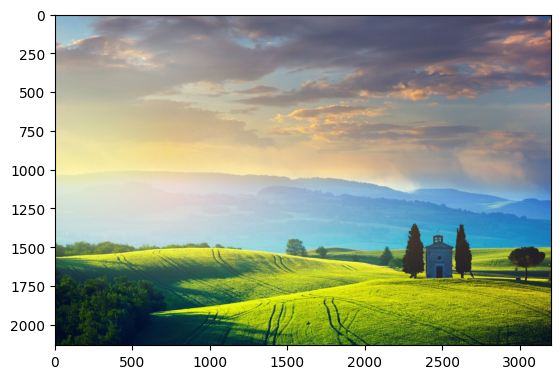

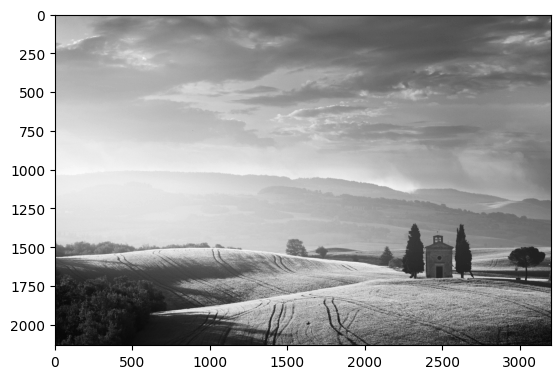

In [23]:
img = cv2.imread('landscape.jpg')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img.shape)
print(img_gray.shape)
plt.imshow(img[:,:,::-1])
plt.show()
plt.imshow(img_gray,cmap='gray')
plt.show()

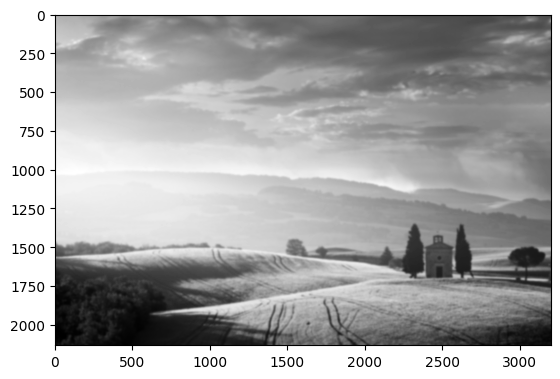

In [43]:
img_blurred = cv2.GaussianBlur(img_gray,(103,103),sigmaX=5,sigmaY=5)
plt.imshow(img_blurred,cmap='gray')

In [106]:
def generate_octave(init_level,s,sigma):
    octave = [init_level]
    k = 2**(1/s)
    for _ in range(s+2):
        next_level = ndimage.gaussian_filter(octave[-1],k*sigma)
        octave.append(next_level)
    return octave
        

def generate_gaussian_pyramid(img,num_octave,s,sigma):
    pyramid = []
    for _ in range(num_octave):
        octave = generate_octave(img,s,sigma)
        pyramid.append(octave)
        img = octave[-3][::2,::2]
    return pyramid

def plot_pyramid(p, sz, s, num_octave, hspace=10,vspace=10):
    rows, cols = sz[0],sz[1]

    nrows = sum([x[0].shape[0] for x in p]) +  vspace*(num_octave-1)
    ncols = cols*(s+3)+hspace*(s+2)
    output_image = np.ones((nrows,ncols))

    r = 0
    for i in range(len(p)):
        c = 0
        for j in range(len(p[i])):
            w,h = p[i][j].shape
            output_image[r:r+w,c:c+h] = p[i][j]
            c += cols + hspace
        r += w + vspace
    
    return output_image

     

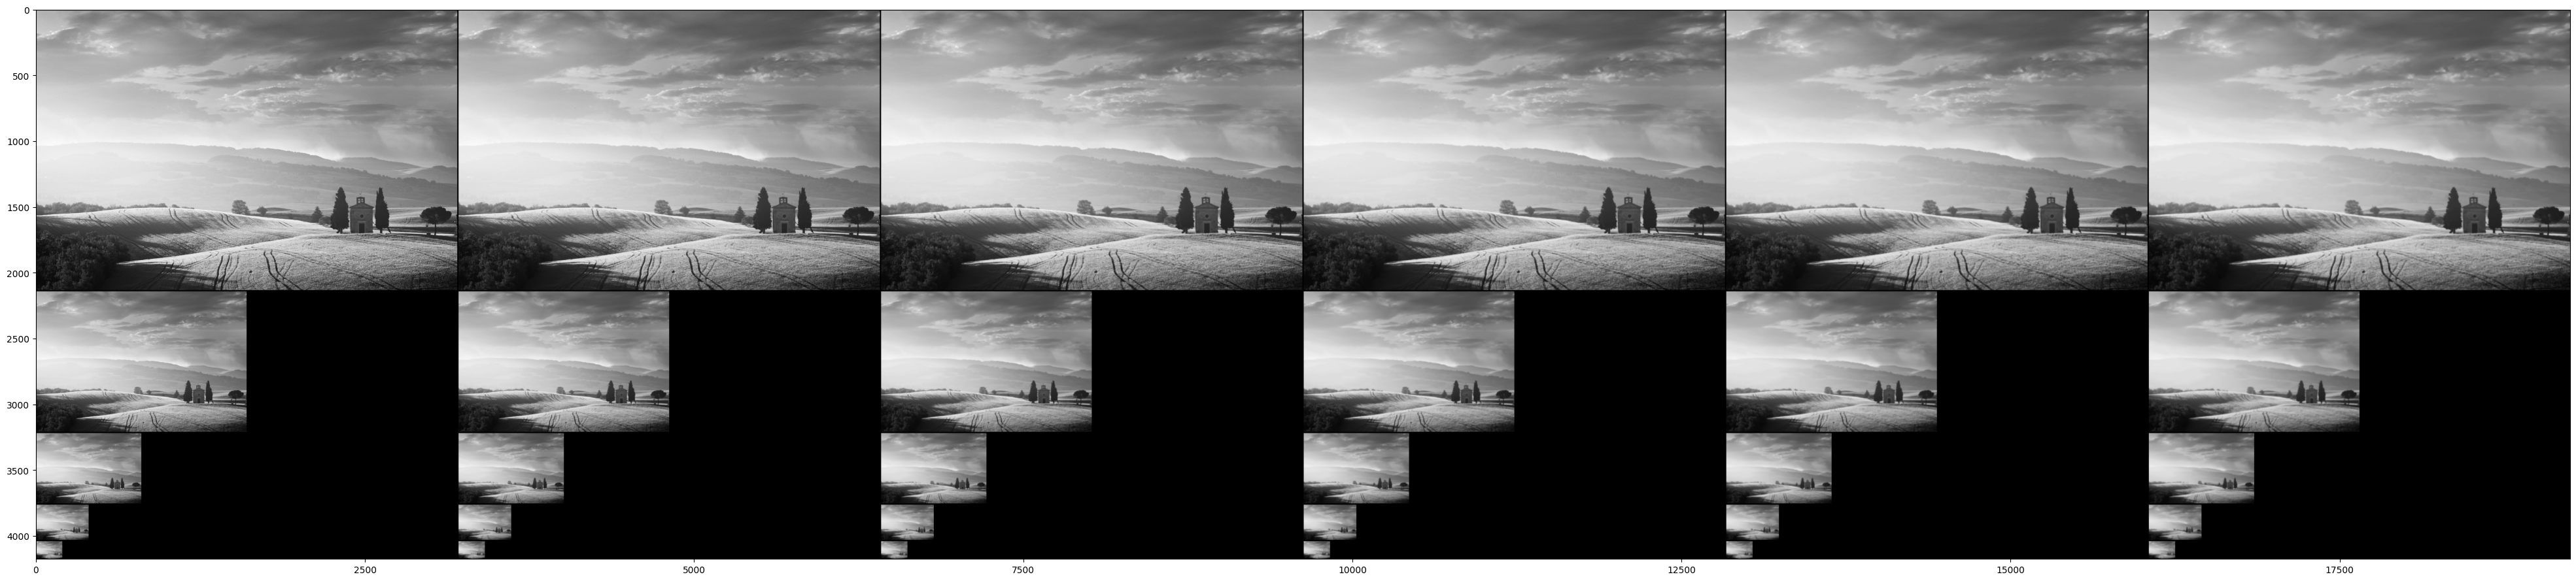

In [108]:
pyramid = generate_gaussian_pyramid(img_gray,num_octave=5,s=3,sigma=1)
fig = plt.figure(figsize=(50,20))

plt.imshow(plot_pyramid(pyramid,img_gray.shape,3,5),cmap='gray')

# GRADIENTE

Data la seguente sequenza di tensori e la funzione f, calcolare il gradiente per i tensori a,b,c,d,e,y.

Descrivere come viene costruito il grafo di computazione mostrando quali operazioni vengono effettuate, cioè calcolando le derivate parziali in maniera esplicita.

non sono necessarie librerie esterne

 


In [109]:
import torch

In [122]:
a = torch.tensor([5, 6, 7, 8, 1, 2], dtype=torch.float, requires_grad=True).view(3, 2)
b = torch.tensor([3, 3, 0, 1, 6, 2], dtype=torch.float, requires_grad=True).view(3, 2)
c = torch.tensor([1, 5, 0, 7, 4, 3], dtype=torch.float, requires_grad=True).view(3, 2)
d = torch.tensor([2, 6, 3, 8, 3, 1], dtype=torch.float, requires_grad=True).view(3, 2)
e = torch.tensor([5, 2, 1, 1, 1, 1], dtype=torch.float, requires_grad=True).view(3, 2)

tensors = [a,b,c,d,e]

for t in tensors:
    t.retain_grad()

x1 = torch.pow(a,5)+torch.exp(torch.pow(b,2))*torch.sin(c*d)
x2 = x1/(3*e)
res = torch.sum(x2)

print(res.item())

res.retain_grad()
res.backward()

print()

print(a.grad)
print(b.grad)
print(c.grad)
print(d.grad)
print(e.grad)



-771096685051904.0

tensor([[2.0833e+02, 1.0800e+03],
        [4.0017e+03, 6.8267e+03],
        [1.6667e+00, 2.6667e+01]])
tensor([[ 2.9472e+03, -8.0061e+03],
        [ 0.0000e+00, -9.4515e-01],
        [-9.2532e+15,  1.0273e+01]])
tensor([[-4.4961e+02,  1.2499e+03],
        [ 1.0000e+00,  6.1848e+00],
        [ 3.6380e+15, -1.8017e+01]])
tensor([[-2.2480e+02,  1.0416e+03],
        [ 0.0000e+00,  5.4117e+00],
        [ 4.8507e+15, -5.4052e+01]])
tensor([[-1.3991e+02,  1.9175e+01],
        [-5.6023e+03, -1.0922e+04],
        [ 7.7110e+14, -1.3235e+01]])


In [124]:
da = 5*torch.pow(a,4)/(3*e)
print(da)

tensor([[2.0833e+02, 1.0800e+03],
        [4.0017e+03, 6.8267e+03],
        [1.6667e+00, 2.6667e+01]], grad_fn=<DivBackward0>)


# BATCHNORM  

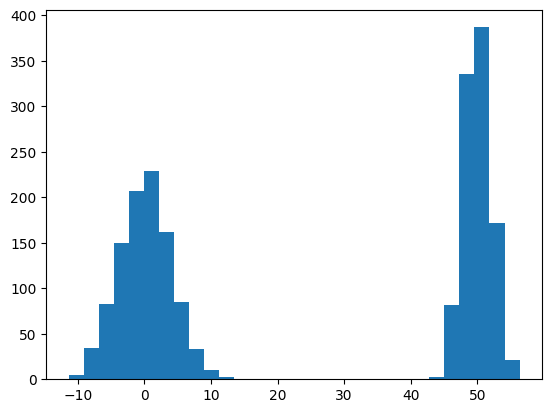

In [149]:
batch_1 = torch.randn((1000))*4
batch_2 = torch.randn((1000))*2+50


batch = torch.cat((batch_1,batch_2),dim=0)

plt.hist(batch,bins=30)
plt.show()

In [151]:
def batch_norm(batch,gamma=10,beta=20):
    eps = 1e-16

    mean = torch.mean(batch)
    var = torch.var(batch)
    ret = ((batch-mean)/torch.sqrt(var+eps))*gamma+beta
    return ret


In [152]:
batch_1_norm = batch_norm(batch_1)
batch_2_norm = batch_norm(batch_2)

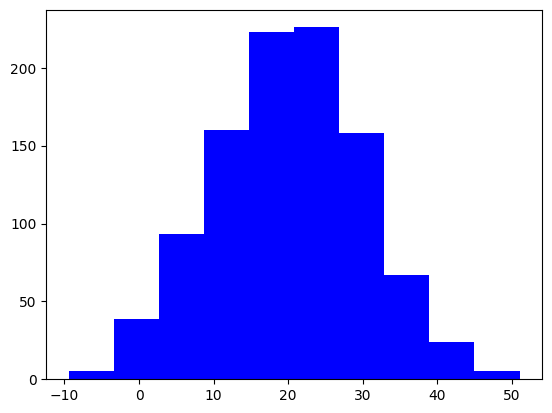

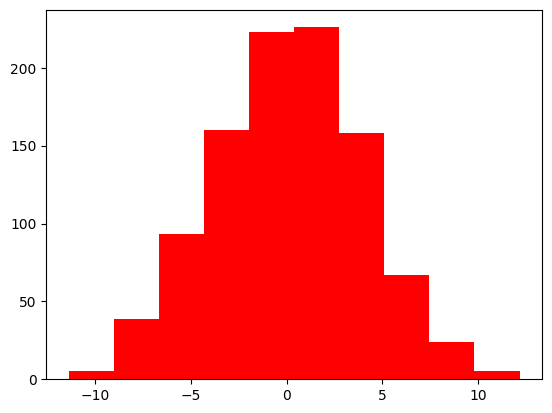

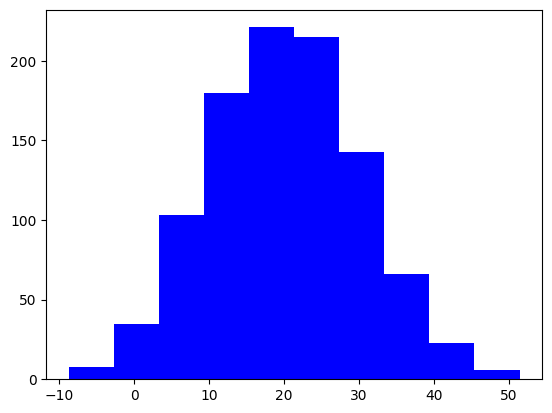

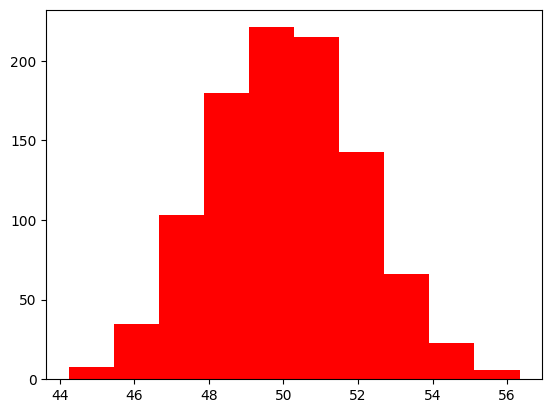

In [153]:
plt.hist(batch_1_norm,color='blue')
plt.show()
plt.hist(batch_1,color='red')
plt.show()


plt.hist(batch_2_norm,color='blue')
plt.show()
plt.hist(batch_2,color='red')
plt.show()


# CONVOLUZIONE 

In [158]:
conv1 = torch.nn.Conv2d(3, 10, kernel_size=3, padding=1, stride=2)
conv2 = torch.nn.Conv2d(10, 30, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))

model = lambda x: conv2(conv1(x))

Indicare giustificando la risposta qual'è il risultato per un'immagine 1x3x400x400 illustrandolo con un esempio.

In [159]:
x = torch.rand((1,3,400,400))
model(x).shape

torch.Size([1, 30, 66, 50])

$$

out = floor \bigg(\frac{dim_{in}+2 \times padding - dilation \times (kernel-1)-1}{stride}+1 \bigg)
$$

In [163]:
def compute_out_dim(in_dim,padding,dilation,kernel,stride):
    return int(np.floor(
        ((in_dim+2*padding-dilation*(kernel-1)-1)/stride)+1
    ))

In [165]:
w_1 = 400
h_1 = 400

w_2 = compute_out_dim(w_1,1,1,3,2)
h_2 = compute_out_dim(h_1,1,1,3,2)

w_3 = compute_out_dim(w_2,0,1,3,3)
h_3 = compute_out_dim(h_2,1,1,5,4)

print(w_2,h_2)
print(w_3,h_3)

200 200
66 50


# VGG

Adattare/semplificare la rete VGG affinché gestisca un input di immagini 400x400


In [166]:
import torch
import torch.nn as nn

In [177]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M', 512,512,512,'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [178]:
vgg16 = VGG(make_layers(cfg['D']))

In [180]:
test = torch.rand((1,3,400,400))
vgg16(test).shape


torch.Size([1, 1000])

# Alex Net

In [205]:
class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1), 
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0)) 
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta
    
    
    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x
    
class AlexNet(nn.Module):
    def __init__(self, num_classes = 1000):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, groups=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, padding=1, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        ###
        self.new_layer = nn.Sequential(
            
            nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2)
            )
        )


        ###


        
        self.layer6 = nn.Sequential(
            nn.Linear(in_features=6*6*256, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer7 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        
        self.layer8 = nn.Linear(in_features=4096, out_features=num_classes)

    def get_features(self,x):
        return self.new_layer(self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x))))))
    
    def forward(self, x):
        x = self.get_features(x)
    
        x = x.view(-1, 6*6*256)
        x = self.layer8(self.layer7(self.layer6(x)))
        
        return x

In [206]:
net = AlexNet()

In [207]:
test = torch.rand((1,3,400,400))
net(test).shape

torch.Size([1, 1000])

# IOU

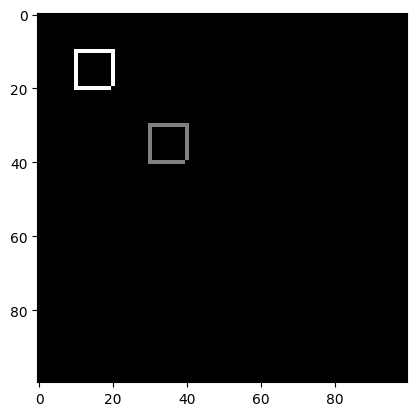

In [295]:

A = [10,10,20,20]
B = [30,30,40,40]

img = np.zeros((100,100))
def plot_bbox(img,A,color=125):
    # plot the bbox
    img = img.copy()
    img[A[0]:A[2],A[1]] = color
    img[A[0]:A[2],A[3]] = color
    img[A[0],A[1]:A[3]] = color
    img[A[2],A[1]:A[3]] = color

    return img
img = plot_bbox(img,A,100)
img = plot_bbox(img,B,50)

plt.imshow(img,cmap='gray')




La IoU è definita come:

$$
    IoU = \frac{A \cap B}{ A \cup B}
$$

In [296]:
def compute_area(X):
    return np.abs(X[0]-X[2])*np.abs(X[1]-X[3])

def find_IoU(A,B):
    x_1 = max(A[0],B[0])
    x_2 = min(A[2],B[2])
    y_1 = max(A[1],B[1])
    y_2 = min(A[3],B[3])

    if x_1 >= x_2 or y_1>=y_2:
        return 0
    intersection = abs((x_1-x_2)*(y_1-y_2))

    union = compute_area(A)+compute_area(B)-intersection

    return intersection/union
    

    
find_IoU(A,B)

0

$$
\frac{intersezione}{unione} = 0.5
$$

$$
intersezione = 0.5 \times (area_A + area_B - intersezione)
$$

$$
3 \times I = A+B
$$

Supponiamo A = 300 e B = 300 => I = (300+300)/3 = 200


A = (0,0) (10,30)
B = (0,20) (10,50)

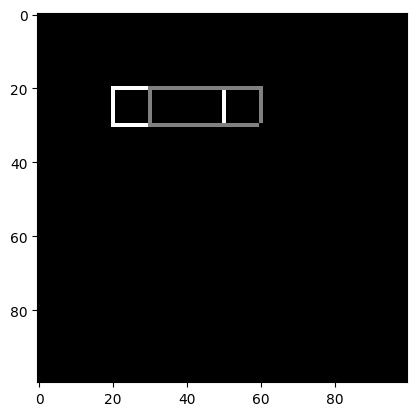

0.5

In [304]:
A = [0,0,10,30] 
B = [0,10,10,40] 
A = [x+20 for x in A]
B = [x+20 for x in B ]



img = np.zeros((100,100))

img = plot_bbox(img,A,100)
img = plot_bbox(img,B,50)

plt.imshow(img,cmap='gray')
plt.show()

find_IoU(A,B)

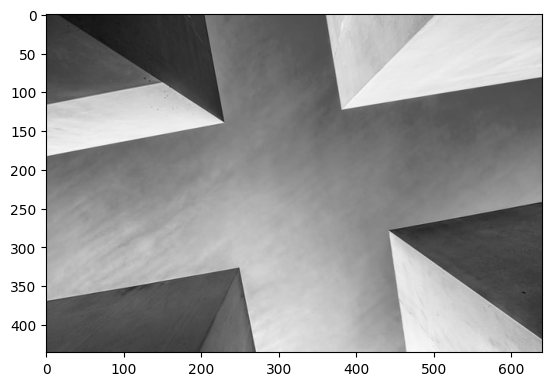

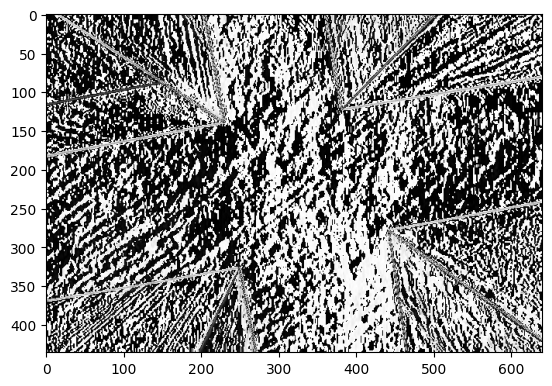

In [342]:
img = cv2.imread('./geom.jpg')[:,:,::-1]
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray,cmap='gray')
plt.show()

sobelH = np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])
sobelV = np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
])
img_gray.shape

# apply sobel filter using ndimage
sobel_out = ndimage.convolve(img_gray,sobelH)


plt.imshow(sobel_out,cmap='gray')




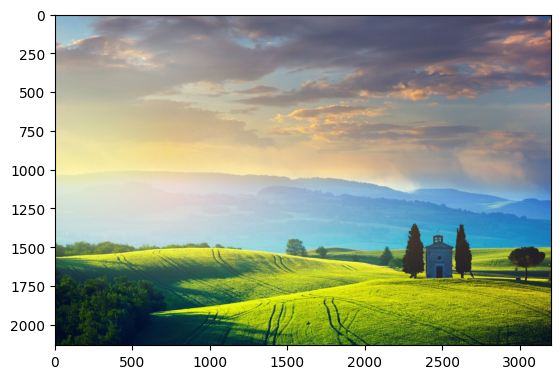

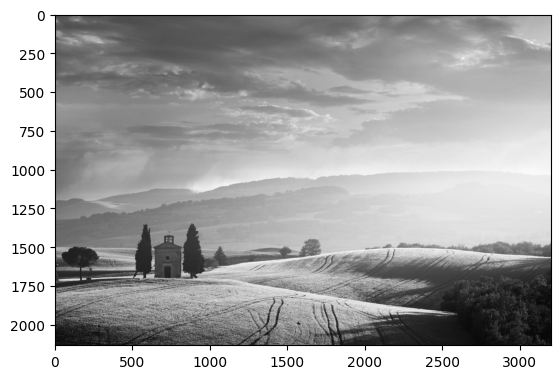

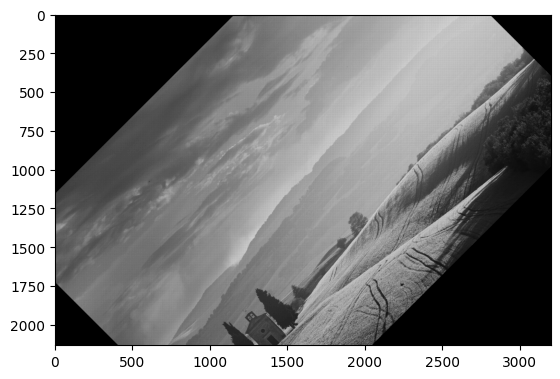

In [365]:
def mirror_image(img):
    img_ret = img[:,::-1]
    return img_ret
def rotate_image(img,theta):
    rotation_matrix = np.array([
        [np.cos(theta),-np.sin(theta)],
        [np.sin(theta),np.cos(theta)],
    ])
    m,n = img.shape
    new_img = np.zeros((m,n))
    center_x = m//2
    center_y = n//2
    new_center = rotation_matrix @ np.array([center_x,center_y])
    offset = (new_center-np.array([center_x,center_y])).astype(int)
    for x in range(m):
        for y in range(n):
            new_pos = rotation_matrix @ np.array([x,y])
            new_pos = new_pos.astype(int)
            if new_pos[0]-offset[0]<0 or new_pos[1]-offset[1]<0 or new_pos[0]-offset[0]> m-1 or new_pos[1]-offset[1]>n-1:
                continue
            new_img[new_pos[0]-offset[0],new_pos[1]-offset[1]] = img[x,y]
    return new_img




img = cv2.imread('./landscape.jpg')[:,:,::-1]
plt.imshow(img)
plt.show()
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img_mirrored = mirror_image(img_gray)
plt.imshow(img_mirrored,cmap='gray')
plt.show()

img_rotated = rotate_image(img_mirrored,np.deg2rad(45))
plt.imshow(img_rotated,cmap='gray')
plt.show()

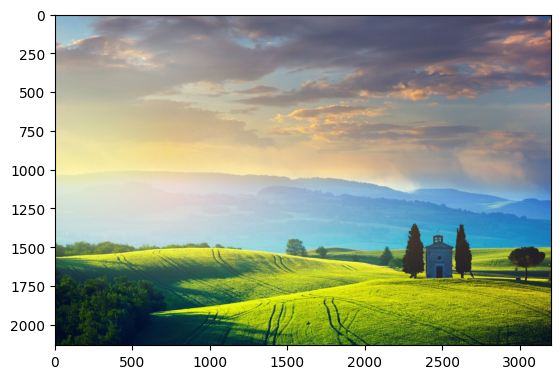

(6, 6)


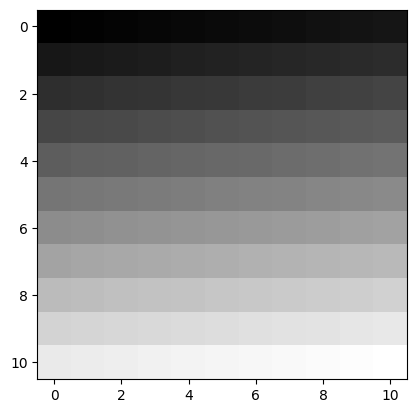

In [374]:
img = cv2.imread('./landscape.jpg')[:,:,::-1]
plt.imshow(img)
plt.show()
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

img_gray = np.linspace(0,121,121).reshape(11,11)
def sample_image(img,n):
    return img[::n,::n]
print(sample_image(img_gray,2).shape)
plt.imshow(sample_image(img_gray,1),cmap='gray')
    

conv1: dilation = 1 e padding = 2
    
    x = tensore con shape 1 x 3 x 200 x 200
    y = tensore con shape 1 x 3 x 100 x 50

    model = lambda x: conv2(conv1(x))

In [387]:
x = torch.rand((1,3,200,200))
y = torch.rand((1,3,100,50))

conv1 = nn.Conv2d(
    3,3,kernel_size=5,dilation=1,padding=2,
)
conv2 = nn.Conv2d(3,3,padding=1,stride=(2,4),kernel_size=3)

out =conv2(conv1(x))
out.shape

torch.Size([1, 3, 100, 50])